In [149]:
# Importing necessary libraries
# For preprocessing
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import re
import numpy as np

# For model training
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Activation

# Data Preprocessing

In [11]:
# Mounting the Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
# Changint the directory to where the zip file of the data is stored
%cd gdrive/MyDrive/TESS

/content/gdrive/MyDrive/TESS


In [ ]:
# Unzipping the data
!unzip data.zip 

In [44]:
# Creating a dataframe out of the files in our dataset
df = pd.DataFrame(columns=["Path","Age","Emotion","Class"])
for file in glob.glob("*.wav"):
# Finding the age of the speaker from the file name
  age = re.findall("YAF|OAF",file)[0]
# Finding the emotion of the speaker from the file name
  emotion = re.findall("[_][a-z]*",file)[1][1:]
# Creating a joint class containing age and emotion
  if age == "OAF":
    age = "Old"
    category = "Old and "+emotion
  else:
    age = "Young"
    category = "Young and "+emotion
# Appending the data into the dataframe
  df = df.append({"Path":file,"Age":age,"Emotion":emotion,"Class":category},ignore_index=True)

In [45]:
# Displaying the dataframe
df

,Path,Age,Emotion,Class
0,OAF_back_angry.wav,Old,angry,Old and angry
1,OAF_back_disgust.wav,Old,disgust,Old and disgust
2,OAF_back_fear.wav,Old,fear,Old and fear
3,OAF_back_happy.wav,Old,happy,Old and happy
4,OAF_back_neutral.wav,Old,neutral,Old and neutral
...,...,...,...,...
2795,YAF_youth_fear.wav,Young,fear,Young and fear
2796,YAF_youth_happy.wav,Young,happy,Young and happy
2797,YAF_youth_neutral.wav,Young,neutral,Young and neutral
2798,YAF_youth_ps.wav,Young,ps,Young and ps


# Visualization

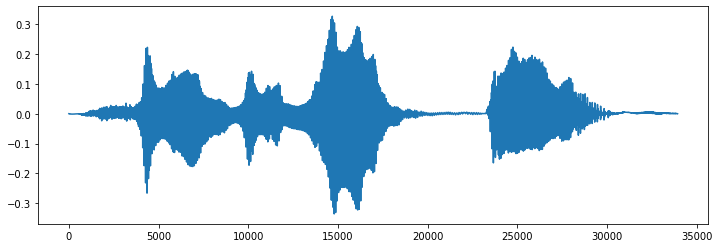

In [47]:
# Visualising the audio signal
audio_file_path=df.iloc[0]["Path"]
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [52]:
# Function to extract the Mel-frequency cepstral coefficients 
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [53]:
# Adding the MFCC column to the dataframe
df["Features"] = df["Path"].apply(lambda x: features_extractor(x))

In [54]:
# Displaying the dataframe
df

,Path,Age,Emotion,Class,Features
0,OAF_back_angry.wav,Old,angry,Old and angry,"[-387.26328, 58.097054, -23.014153, -6.4362707..."
1,OAF_back_disgust.wav,Old,disgust,Old and disgust,"[-487.85187, 97.89603, 2.2619627, 3.044031, 5...."
2,OAF_back_fear.wav,Old,fear,Old and fear,"[-439.19592, 68.50909, -4.808176, -1.632796, -..."
3,OAF_back_happy.wav,Old,happy,Old and happy,"[-471.6008, 91.209015, 3.2708466, -4.7777486, ..."
4,OAF_back_neutral.wav,Old,neutral,Old and neutral,"[-532.4035, 93.87202, 6.0608063, 9.067057, 7.7..."
...,...,...,...,...,...
2795,YAF_youth_fear.wav,Young,fear,Young and fear,"[-343.40387, 32.59755, -9.197987, 25.315775, 0..."
2796,YAF_youth_happy.wav,Young,happy,Young and happy,"[-345.47714, 24.427338, -14.398651, 36.952995,..."
2797,YAF_youth_neutral.wav,Young,neutral,Young and neutral,"[-416.72632, 71.14924, -1.1160213, 42.524796, ..."
2798,YAF_youth_ps.wav,Young,ps,Young and ps,"[-374.82404, 46.68187, -12.381617, 18.139086, ..."


In [55]:
# Saving the dataframe into a csv file 
df.to_csv("TESS.csv")

# Model Training

## For Age Classification

In [167]:
# Creating the features and target arrays
X = np.array(df["Features"].to_list())
y = df["Age"].values

In [168]:
# Encoding the categorical target array
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 0, 0, ..., 1, 1, 1])

In [169]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [170]:
X_train.shape

(2100, 40)

In [171]:
# Creating a sequential model
model = Sequential()
# Adding a dense layer of 100 neurons
model.add(Dense(100))
# Applying 'relu' activation 
model.add(Activation('relu'))
# Applying dropout with probability of 0.2
model.add(Dropout(0.2))
model.add(Flatten())
# Adding a dense layer of 1 neuron
model.add(Dense(1))
# Applying 'sigmoid' activation 
model.add(Activation('sigmoid'))

In [172]:
# Compiling the model with 'binary_crossentropy' as loss and 'rmsprop' as the optimizer 
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='rmsprop')

In [173]:
num_epochs = 100
num_batch_size = 64
# Fitting the model
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 10.6632 - accuracy: 0.6488 - val_loss: 0.0238 - val_accuracy: 0.9929
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 2.2643 - accuracy: 0.8388 - val_loss: 0.0057 - val_accuracy: 0.9986
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.7338 - accuracy: 0.9282 - val_loss: 1.7042e-04 - val_accuracy: 1.0000
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.9597 - val_loss: 0.0085 - val_accuracy: 0.9971
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.9736 - val_loss: 2.2209e-04 - val_accuracy: 1.0000
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1157 - accuracy: 0.9853 - val_loss: 3.3500e-07 - val_accuracy: 1.0000
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.9976 - val_loss: 6.0001e-06 - val_accuracy: 1.0

''

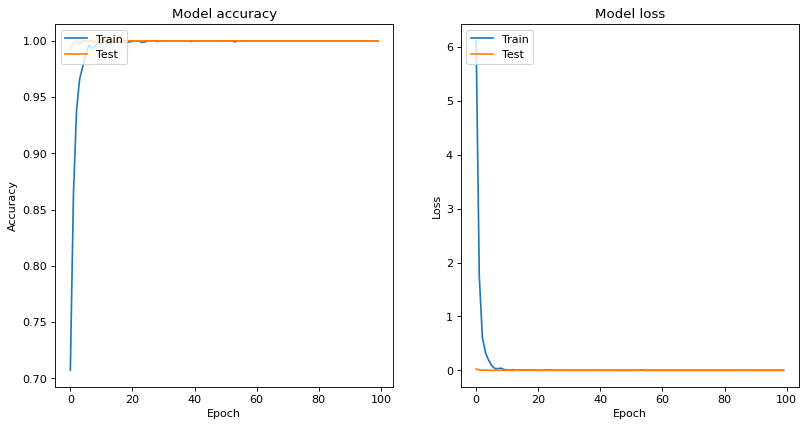

In [174]:
# Visualizing the loss and accuracy
plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.plot()
plt.show()

In [175]:
# Saving the model
age_model = model
age_model.save("age_model.h5")

## For Emotion Classification

In [176]:
# Creating the features and target arrays
X = np.array(df["Features"].to_list())
y = df["Emotion"].values

In [177]:
# Encoding the categorical target array
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [178]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [179]:
# Creating a sequential model
model = Sequential()
# Adding a dense layer of 100 neurons
model.add(Dense(100))
# Applying 'relu' activation 
model.add(Activation('relu'))
# Applying dropout with probability of 0.2
model.add(Dropout(0.2))
model.add(Flatten())
# Adding a dense layer of 7 neurons
model.add(Dense(7))
# Applying 'softmax' activation 
model.add(Activation('softmax'))

In [180]:
# Compiling the model with 'categorical_crossentropy' as loss and 'rmsprop' as the optimizer 
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='rmsprop')

In [181]:
num_epochs = 100
num_batch_size = 64
# Fitting the model
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 52.2338 - accuracy: 0.1488 - val_loss: 4.6922 - val_accuracy: 0.5586
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 16.1990 - accuracy: 0.3216 - val_loss: 1.9600 - val_accuracy: 0.7286
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 8.5359 - accuracy: 0.4616 - val_loss: 0.9313 - val_accuracy: 0.8043
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 4.2989 - accuracy: 0.6089 - val_loss: 0.5263 - val_accuracy: 0.8700
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 2.4362 - accuracy: 0.7069 - val_loss: 0.4739 - val_accuracy: 0.8914
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 1.2465 - accuracy: 0.7994 - val_loss: 0.3509 - val_accuracy: 0.9186
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.8746 - val_loss: 0.1324 - val_accuracy: 0.9614
Epoch 8/100

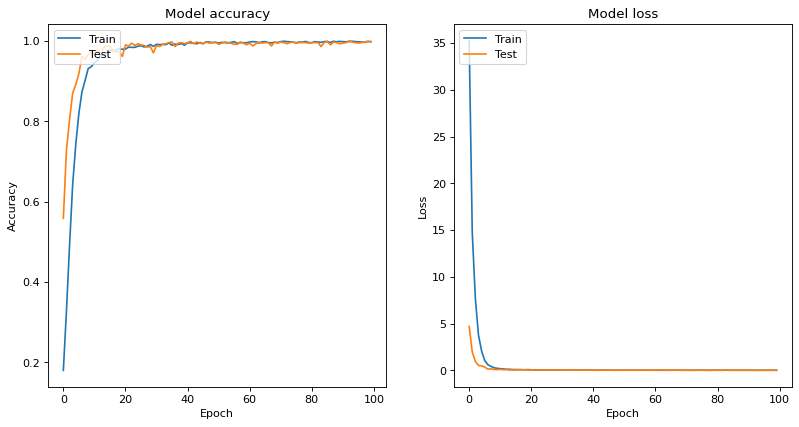

In [182]:
# Visualizing the loss and accuracy
plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.plot()
plt.show()

In [183]:
# Saving the model
emotion_model = model
emotion_model.save("emotion_model.h5")

## For Joint Classification

In [184]:
# Creating the features and target arrays
X = np.array(df["Features"].to_list())
y = df["Class"].values

In [185]:
# Encoding the categorical target array
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [186]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [187]:
# Creating a sequential model
model = Sequential()
# Adding a dense layer of 100 neurons
model.add(Dense(100))
# Applying 'relu' activation 
model.add(Activation('relu'))
# Applying dropout with probability of 0.2
model.add(Dropout(0.2))
model.add(Flatten())
# Adding a dense layer of 14 neurons
model.add(Dense(14))
# Applying 'softmax' activation 
model.add(Activation('softmax'))

In [188]:
# Compiling the model with 'categorical_crossentropy' as loss and 'rmsprop' as the optimizer 
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='rmsprop')

In [189]:
num_epochs = 100
num_batch_size = 64
# Fitting the model
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 47.7004 - accuracy: 0.0850 - val_loss: 3.1971 - val_accuracy: 0.4214
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 16.0677 - accuracy: 0.2122 - val_loss: 1.1951 - val_accuracy: 0.6929
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 8.5250 - accuracy: 0.3333 - val_loss: 0.6506 - val_accuracy: 0.7957
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 3.7131 - accuracy: 0.5464 - val_loss: 0.2235 - val_accuracy: 0.9171
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.5218 - accuracy: 0.6982 - val_loss: 0.1214 - val_accuracy: 0.9571
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.8327 - val_loss: 0.0942 - val_accuracy: 0.9700
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.3692 - accuracy: 0.8943 - val_loss: 0.0779 - val_accuracy: 0.9714
Epoch 8/100

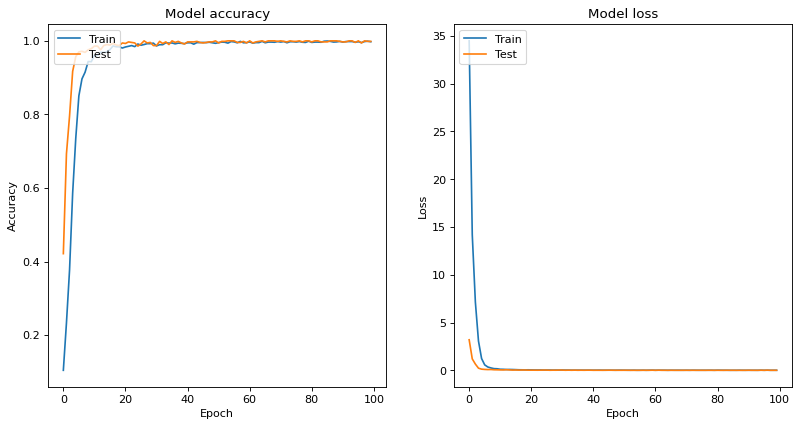

In [190]:
# Visualizing the loss and accuracy
plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.plot()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.plot()
plt.show()

In [191]:
# Saving the model
joint_model = model
joint_model.save("joint_model.h5")

# Results

Model| Training Accuracy  |Validation Accuracy|
-----|--|--|
Age| 100% | 100% |
Emotion| 99.86% | 99.71% |
Joint| 99.94% | 99.86% |